In [1]:
# Variational Classifier 
#Group: Samukelo Mfusi (218038507),  Khayelihle Ntuli (220036123), Ntethelelo Shabalala (218052341)
#Project: COMP718W2 Project - Variational Classifier

#Notebook structure:
#1. Exact reproduction of the PennyLane Variational Classifier tutorial (parity example then Iris example).  
#   - Replicates tutorial functions: layer, state_preparation, get_angles, circuit, variational_classifier, square_loss, accuracy, cost.

#2. Extensions:
#   - Extra datasets: Breast Cancer and Wine (2-class subset)
#   - Angle Embedding
#   - Amplitude Embedding
#   - Classical baselines
#   - Circuit depth
#   - Capacity curve
#   - Noise sweeps
#   - Transfer learning across datasets
#   - Optimizer comparisons, noise simulation, ensemble

#3. Evaluation: confusion matrices, ROC/AUC, and plotting decision regions.

#4. ENSURE YOU HAVE THE FOLDER variational_classifier/data with the following datasets: iris_classes1and2_scaled.txt, parity_test.txt, and parity_train.txt

#5. Should execute 49/49 cells, no errors, allow some time to run. Steps were reduced for faster execution.


In [2]:
# Imports and reproducibility
import pennylane as qml
from pennylane import numpy as np
from pennylane import templates
from pennylane.optimize import NesterovMomentumOptimizer, AdamOptimizer

import os, pickle
import matplotlib.pyplot as plt
import numpy as onp 
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# reproducibility
np.random.seed(0)
onp.random.seed(0)

In [3]:
#PART I - Parity example (tutorial reproduction)

In [4]:
dev = qml.device("default.qubit")

In [5]:
#Parity functions
def layer(layer_weights):
    # layer_weights is shape (4, 3) in tutorial for 4 wires
    for wire in range(4):
        qml.Rot(*layer_weights[wire], wires=wire)
    # entangling ring
    for wires in ([0,1], [1,2], [2,3], [3,0]):
        qml.CNOT(wires)

def state_preparation(x):
    # x must be a list/array of bits length 4
    qml.BasisState(x, wires=[0,1,2,3])

@qml.qnode(dev)
def circuit(weights, x):
    state_preparation(x)
    for layer_weights in weights:
        layer(layer_weights)
    return qml.expval(qml.PauliZ(0))

def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

In [6]:
#Helper functions
#We reproduce square_loss and accuracy as in the tutorial.

In [7]:
#Loss and accuracy (as in tutorial)
def square_loss(labels, predictions):
    return np.mean((labels - qml.math.stack(predictions)) ** 2)

def accuracy(labels, predictions):
    acc = sum(abs(l - p) < 1e-5 for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    return acc

In [8]:
#Prepare the parity dataset

In [9]:
def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

In [10]:
data = np.loadtxt("variational_classifier/data/parity_train.txt", dtype=int)
X = np.array(data[:, :-1])
Y = np.array(data[:, -1])
Y = Y * 2 - 1  # shift label from {0, 1} to {-1, 1}

for x,y in zip(X, Y):
    print(f"x = {x}, y = {y}")

x = [0 0 0 1], y = 1
x = [0 0 1 0], y = 1
x = [0 1 0 0], y = 1
x = [0 1 0 1], y = -1
x = [0 1 1 0], y = -1
x = [0 1 1 1], y = 1
x = [1 0 0 0], y = 1
x = [1 0 0 1], y = -1
x = [1 0 1 1], y = 1
x = [1 1 1 1], y = -1


In [11]:
np.random.seed(0)
num_qubits = 4
num_layers = 2
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

print("Weights:", weights_init)
print("Bias: ", bias_init)

Weights: [[[ 0.01764052  0.00400157  0.00978738]
  [ 0.02240893  0.01867558 -0.00977278]
  [ 0.00950088 -0.00151357 -0.00103219]
  [ 0.00410599  0.00144044  0.01454274]]

 [[ 0.00761038  0.00121675  0.00443863]
  [ 0.00333674  0.01494079 -0.00205158]
  [ 0.00313068 -0.00854096 -0.0255299 ]
  [ 0.00653619  0.00864436 -0.00742165]]]
Bias:  0.0


In [12]:
opt = NesterovMomentumOptimizer(0.5)
batch_size = 5

In [13]:
weights = weights_init
bias = bias_init
for it in range(100):

    # Update the weights by one optimizer step, using only a limited batch of data
    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, bias = opt.step(cost, weights, bias, X=X_batch, Y=Y_batch)

    # Compute accuracy
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X]

    current_cost = cost(weights, bias, X, Y)
    acc = accuracy(Y, predictions)

    print(f"Iter: {it+1:4d} | Cost: {current_cost:0.7f} | Accuracy: {acc:0.7f}")

Iter:    1 | Cost: 2.3147651 | Accuracy: 0.5000000
Iter:    2 | Cost: 1.9664866 | Accuracy: 0.5000000
Iter:    3 | Cost: 1.9208589 | Accuracy: 0.5000000
Iter:    4 | Cost: 2.6276126 | Accuracy: 0.5000000
Iter:    5 | Cost: 0.9323119 | Accuracy: 0.6000000
Iter:    6 | Cost: 1.1903549 | Accuracy: 0.5000000
Iter:    7 | Cost: 2.0508989 | Accuracy: 0.4000000
Iter:    8 | Cost: 1.1275531 | Accuracy: 0.6000000
Iter:    9 | Cost: 1.1659803 | Accuracy: 0.6000000
Iter:   10 | Cost: 1.1349618 | Accuracy: 0.6000000
Iter:   11 | Cost: 0.9994063 | Accuracy: 0.6000000
Iter:   12 | Cost: 1.0812559 | Accuracy: 0.6000000
Iter:   13 | Cost: 1.2863155 | Accuracy: 0.6000000
Iter:   14 | Cost: 2.2658259 | Accuracy: 0.4000000
Iter:   15 | Cost: 1.1323724 | Accuracy: 0.6000000
Iter:   16 | Cost: 1.3439737 | Accuracy: 0.8000000
Iter:   17 | Cost: 2.0076168 | Accuracy: 0.6000000
Iter:   18 | Cost: 1.2685760 | Accuracy: 0.5000000
Iter:   19 | Cost: 1.6762475 | Accuracy: 0.5000000
Iter:   20 | Cost: 1.1868237 | 

In [14]:
#Evaluate the tutorial`s test set

In [15]:
data = np.loadtxt("variational_classifier/data/parity_test.txt", dtype=int)
X_test = np.array(data[:, :-1])
Y_test = np.array(data[:, -1])
Y_test = Y_test * 2 - 1  # shift label from {0, 1} to {-1, 1}

predictions_test = [np.sign(variational_classifier(weights, bias, x)) for x in X_test]

for x,y,p in zip(X_test, Y_test, predictions_test):
    print(f"x = {x}, y = {y}, pred={p}")

acc_test = accuracy(Y_test, predictions_test)
print("Accuracy on unseen data:", acc_test)

x = [0 0 0 0], y = -1, pred=-1.0
x = [0 0 1 1], y = -1, pred=-1.0
x = [1 0 1 0], y = -1, pred=-1.0
x = [1 1 1 0], y = 1, pred=1.0
x = [1 1 0 0], y = -1, pred=-1.0
x = [1 1 0 1], y = 1, pred=1.0
Accuracy on unseen data: 1.0


In [16]:
#PART II - Iris classification (tutorial reproduction)

In [17]:
#get_angles and state_preparation (from tutorial)
def get_angles(x):
    # x is expected to be a 4-dimensional vector (positive components)
    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(np.linalg.norm(x[2:]) / np.linalg.norm(x))
    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])

def state_preparation(a):
    # a is the angles vector returned by get_angles
    qml.RY(a[0], wires=0)
    qml.CNOT(wires=[0,1])
    qml.RY(a[1], wires=1)
    qml.CNOT(wires=[0,1])
    qml.RY(a[2], wires=1)
    qml.PauliX(wires=0)
    qml.CNOT(wires=[0,1])
    qml.RY(a[3], wires=1)
    qml.CNOT(wires=[0,1])
    qml.RY(a[4], wires=1)
    qml.PauliX(wires=0)

In [18]:
x = np.array([0.53896774, 0.79503606, 0.27826503, 0.0], requires_grad=False)
ang = get_angles(x)


@qml.qnode(dev)
def test(angles):
    state_preparation(angles)

    return qml.state()


state = test(ang)

print("x               : ", np.round(x, 6))
print("angles          : ", np.round(ang, 6))
print("amplitude vector: ", np.round(np.real(state), 6))

x               :  [0.538968 0.795036 0.278265 0.      ]
angles          :  [ 0.563975 -0.        0.       -0.975046  0.975046]
amplitude vector:  [ 0.538968  0.795036  0.278265 -0.      ]


In [19]:
#We now create the 2-qubit layer function
#and define circuit, variational_classifier, and cost specialized for Iris features

In [20]:
#Iris layer and circuit (tutorial-style)
dev = qml.device("default.qubit", wires=2)

def layer(layer_weights):
    for wire in range(2):
        qml.Rot(*layer_weights[wire], wires=wire)
    qml.CNOT(wires=[0, 1])

@qml.qnode(dev)
def circuit(weights, x):
    state_preparation(x)
    for layer_weights in weights:
        layer(layer_weights)
    return qml.expval(qml.PauliZ(0))

def variational_classifier_iris(weights, bias, x):
    return circuit(weights, x) + bias

def square_loss_tutorial(labels, predictions):
    # tutorial uses qml.math.stack; use the same wrapper
    return np.mean((labels - qml.math.stack(predictions)) ** 2)

def cost(weights, bias, X, Y):
    # Transpose the batch of input data in order to make the indexing
    # in state_preparation work
    predictions = variational_classifier(weights, bias, X.T)
    return square_loss(Y, predictions)


In [21]:
#Load Iris (first two classes as in tutorial), pad vectors to size 4, normalize, then compute features = [get_angles(x) for x in X_norm]

In [22]:
data = np.loadtxt("variational_classifier/data/iris_classes1and2_scaled.txt")
X = data[:, 0:2]
print(f"First X sample (original)  : {X[0]}")

# pad the vectors to size 2^2=4 with constant values
padding = np.ones((len(X), 2)) * 0.1
X_pad = np.c_[X, padding]
print(f"First X sample (padded)    : {X_pad[0]}")

# normalize each input
normalization = np.sqrt(np.sum(X_pad**2, -1))
X_norm = (X_pad.T / normalization).T
print(f"First X sample (normalized): {X_norm[0]}")

# the angles for state preparation are the features
features = np.array([get_angles(x) for x in X_norm], requires_grad=False)
print(f"First features sample      : {features[0]}")

Y = data[:, -1]

First X sample (original)  : [0.4  0.75]
First X sample (padded)    : [0.4  0.75 0.1  0.1 ]
First X sample (normalized): [0.46420708 0.87038828 0.11605177 0.11605177]
First features sample      : [ 0.32973573 -0.78539816  0.78539816 -1.080839    1.080839  ]


In [23]:
#plot the stages of preprocessing and play around with the dimensions (dim1, dim2)

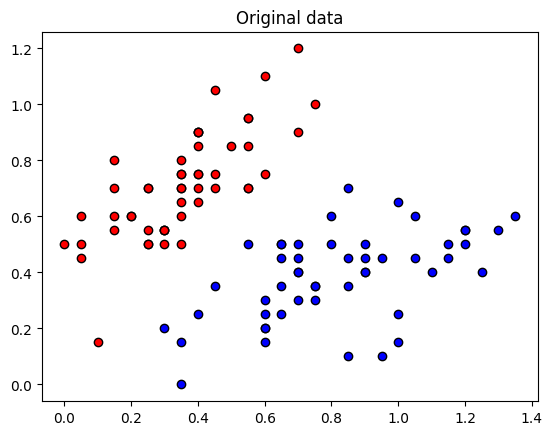

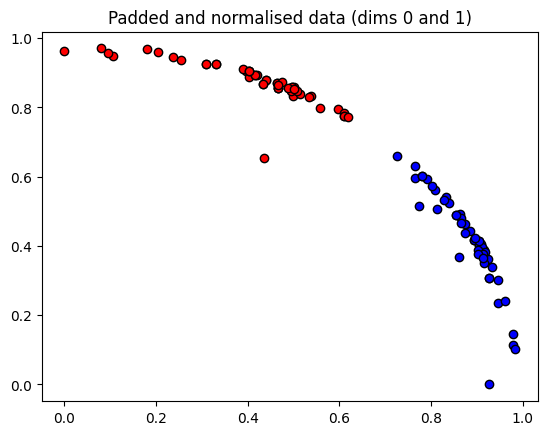

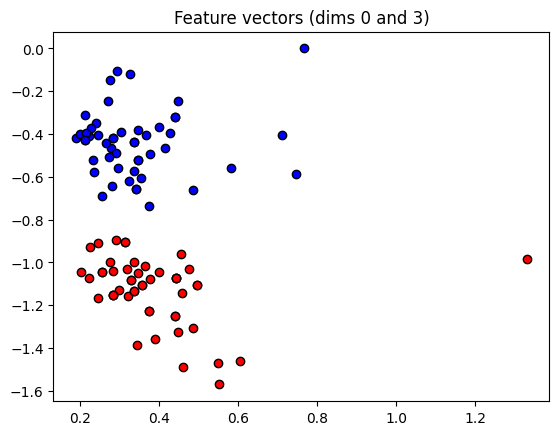

In [24]:
plt.figure()
plt.scatter(X[:, 0][Y == 1], X[:, 1][Y == 1], c="b", marker="o", ec="k")
plt.scatter(X[:, 0][Y == -1], X[:, 1][Y == -1], c="r", marker="o", ec="k")
plt.title("Original data")
plt.show()

plt.figure()
dim1 = 0
dim2 = 1
plt.scatter(X_norm[:, dim1][Y == 1], X_norm[:, dim2][Y == 1], c="b", marker="o", ec="k")
plt.scatter(X_norm[:, dim1][Y == -1], X_norm[:, dim2][Y == -1], c="r", marker="o", ec="k")
plt.title(f"Padded and normalised data (dims {dim1} and {dim2})")
plt.show()

plt.figure()
dim1 = 0
dim2 = 3
plt.scatter(features[:, dim1][Y == 1], features[:, dim2][Y == 1], c="b", marker="o", ec="k")
plt.scatter(features[:, dim1][Y == -1], features[:, dim2][Y == -1], c="r", marker="o", ec="k")
plt.title(f"Feature vectors (dims {dim1} and {dim2})")
plt.show()

In [25]:
#Training Iris example
# Prepare train/validation splits exactly like tutorial (75% train, 25% val)
np.random.seed(0)
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]
feats_val = features[index[num_train:]]
Y_val = Y[index[num_train:]]

# For plotting later, original X (before padding) train/val
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]

# convert features into the shape expected by tutorial's cost variant:
# tutorial uses feats_train.T shape for state_preparation to handle multiple inputs at once.
# We'll keep features per-sample but reproduce their behavior by calling get_angles inside state_preparation
# For simplicity: we will pass a single sample to circuit at each step, and in evaluation we vectorize.

# Initialize weights and bias 
num_qubits = 2
num_layers = 6
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

opt = NesterovMomentumOptimizer(0.01)
batch_size = 5

weights = weights_init
bias = bias_init

# Helper: predict over array of features
def predict_iris(weights, bias, feats):
    # feats: array shape (N, 5) of angles; for each a in feats call variational_classifier_iris
    preds = [variational_classifier_iris(weights, bias, a) for a in feats]
    return np.array([float(p) for p in preds])
    
opt = NesterovMomentumOptimizer(0.01)
batch_size = 5

# Training loop
for it in range(60):
    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, feats_train_batch, Y_train_batch)

    # Compute predictions on train and validation set
    predictions_train = np.sign(variational_classifier(weights, bias, feats_train.T))
    predictions_val = np.sign(variational_classifier(weights, bias, feats_val.T))

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)

    if (it + 1) % 2 == 0:
        _cost = cost(weights, bias, features, Y)
        print(
            f"Iter: {it + 1:5d} | Cost: {_cost:0.7f} | "
            f"Acc train: {acc_train:0.7f} | Acc validation: {acc_val:0.7f}"
        )


Iter:     2 | Cost: 1.6589456 | Acc train: 0.4800000 | Acc validation: 0.5600000
Iter:     4 | Cost: 1.2054273 | Acc train: 0.4933333 | Acc validation: 0.5600000
Iter:     6 | Cost: 0.9740740 | Acc train: 0.4933333 | Acc validation: 0.7200000
Iter:     8 | Cost: 0.9660872 | Acc train: 0.6400000 | Acc validation: 0.6400000
Iter:    10 | Cost: 0.9569019 | Acc train: 0.6000000 | Acc validation: 0.6000000
Iter:    12 | Cost: 0.9445863 | Acc train: 0.4933333 | Acc validation: 0.7200000
Iter:    14 | Cost: 1.0339978 | Acc train: 0.4800000 | Acc validation: 0.5600000
Iter:    16 | Cost: 1.0774217 | Acc train: 0.4933333 | Acc validation: 0.5600000
Iter:    18 | Cost: 0.9984426 | Acc train: 0.4800000 | Acc validation: 0.5600000
Iter:    20 | Cost: 0.8975279 | Acc train: 0.5600000 | Acc validation: 0.7600000
Iter:    22 | Cost: 0.8451699 | Acc train: 0.6400000 | Acc validation: 0.6400000
Iter:    24 | Cost: 0.8337489 | Acc train: 0.5600000 | Acc validation: 0.5200000
Iter:    26 | Cost: 0.783202

In [26]:
#Plot the continuous model output for a grid over the first two input dims (padding + normalization + get_angles, then feed through classifier) to visualize decision region.

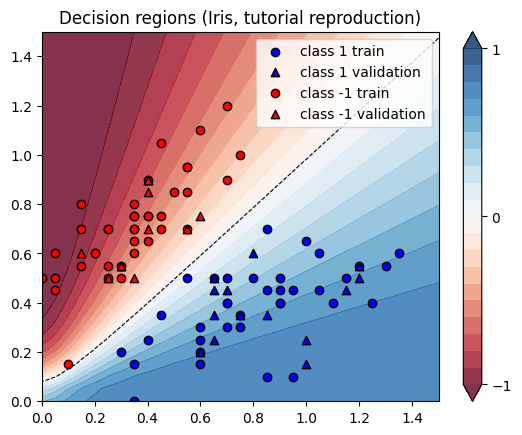

In [27]:
#Plot decision regions
plt.figure()
cm = plt.cm.RdBu

# make data for decision regions
xx, yy = np.meshgrid(np.linspace(0.0, 1.5, 30), np.linspace(0.0, 1.5, 30))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

# preprocess grid points like data inputs above
padding = 0.1 * np.ones((len(X_grid), 2))
X_grid = np.c_[X_grid, padding]  # pad each input
normalization = np.sqrt(np.sum(X_grid**2, -1))
X_grid = (X_grid.T / normalization).T  # normalize each input
features_grid = np.array([get_angles(x) for x in X_grid])  # angles are new features
predictions_grid = variational_classifier(weights, bias, features_grid.T)
Z = np.reshape(predictions_grid, xx.shape)

# plot decision regions
levels = np.arange(-1, 1.1, 0.1)
cnt = plt.contourf(xx, yy, Z, levels=levels, cmap=cm, alpha=0.8, extend="both")
plt.contour(xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[-1, 0, 1])

# plot data
for color, label in zip(["b", "r"], [1, -1]):
    plot_x = X_train[:, 0][Y_train == label]
    plot_y = X_train[:, 1][Y_train == label]
    plt.scatter(plot_x, plot_y, c=color, marker="o", ec="k", label=f"class {label} train")
    plot_x = (X_val[:, 0][Y_val == label],)
    plot_y = (X_val[:, 1][Y_val == label],)
    plt.scatter(plot_x, plot_y, c=color, marker="^", ec="k", label=f"class {label} validation")

plt.legend()
plt.title("Decision regions (Iris, tutorial reproduction)")
plt.show()


In [28]:
#Summary (reproduction)
#The parity and Iris examples have been reproduced following the tutorial function-by-function.
#We used the tutorial's layer, state_preparation, get_angles, circuit, variational_classifier, square_loss, accuracy, and optimizer usage.
#Next: we extend the project - add extra datasets: 
#   -Breast Cancer and Wine (2-class subset)
#   - Angle Embedding
#   - Amplitude Embedding
#   - Classical baselines
#   - Circuit depth
#   - Capacity curve
#   - Noise sweeps
#   - Transfer learning across datasets
#   - Optimizer comparisons, noise simulation, ensemble

In [29]:
# Extensions start here
#We add dataset loaders and utility wrappers to run additional experiments.

In [30]:
#Dataset loaders for extensions
def load_iris_2features():
    # reuse X, Y computed earlier but provide fresh loader
    iris = datasets.load_iris()
    X = iris.data
    y = iris.target
    mask = y != 2
    X = X[mask][:, :2]
    y = y[mask]
    y = (y * 2) - 1
    return X, y

def load_breast_cancer(n_components=None):
    data = datasets.load_breast_cancer()
    X = data.data
    y = data.target
    if n_components is not None:
        X = PCA(n_components=n_components).fit_transform(X)
    X = StandardScaler().fit_transform(X)
    y = (y * 2) - 1
    return X, y

def load_wine_2class(n_components=None):
    data = datasets.load_wine()
    X = data.data
    y = data.target
    mask = y != 2
    X = X[mask]
    y = y[mask]
    if n_components is not None:
        X = PCA(n_components=n_components).fit_transform(X)
    X = StandardScaler().fit_transform(X)
    y = (y * 2) - 1
    return X, y


In [31]:
#We provide a small wrapper implementing AngleEmbedding and AmplitudeEmbedding circuits and a train function
#compatible with these circuits. This is an extension.

In [32]:
#Extension circuits and train wrapper (modern templates for extensions)
def angle_vqc_circuit(n_wires, n_layers, device):
    wires = list(range(n_wires))
    @qml.qnode(device, interface='autograd')
    def circ(weights, x):
        qml.templates.AngleEmbedding(x, wires=wires, rotation='Y')
        qml.templates.StronglyEntanglingLayers(weights, wires=wires)
        return qml.expval(qml.PauliZ(0))
    return circ

def amplitude_vqc_circuit(n_wires, n_layers, device):
    wires = list(range(n_wires))
    @qml.qnode(device, interface='autograd')
    def circ(weights, x):
        qml.templates.AmplitudeEmbedding(x, wires=wires, normalize=True)
        qml.templates.StronglyEntanglingLayers(weights, wires=wires)
        return qml.expval(qml.PauliZ(0))
    return circ

# Generic train wrapper (uses Pennylane optimizers)
def train_generic_vqc(circuit, weights_shape, X_train, y_train, X_test, y_test,
                      optimizer='Adam', lr=0.1, steps=10, batch_size=None, seed=0):
    np.random.seed(seed)
    weights = np.random.randn(*weights_shape, requires_grad=True) * 0.01
    bias = np.array(0.0, requires_grad=True)

    if optimizer.lower() == 'adam':
        opt = AdamOptimizer(lr)
    elif optimizer.lower().startswith('nester'):
        opt = NesterovMomentumOptimizer(lr)
    else:
        from pennylane.optimize import GradientDescentOptimizer
        opt = GradientDescentOptimizer(lr)

    n = X_train.shape[0]
    if batch_size is None:
        batch_size = n

    costs, train_accs, test_accs = [], [], []
    for it in range(steps):
        idx = onp.random.randint(0, n, (batch_size,))
        Xb = X_train[idx]; Yb = y_train[idx]
        def cost_fn(w, b):
            preds = [circuit(w, x) + b for x in Xb]
            return square_loss_tutorial(Yb, preds)
        weights, bias = opt.step(cost_fn, weights, bias)
        # evaluate
        train_preds = [np.sign(circuit(weights, x) + bias) for x in X_train]
        test_preds = [np.sign(circuit(weights, x) + bias) for x in X_test]
        costs.append(float(cost_fn(weights, bias)))
        train_accs.append(accuracy(y_train, train_preds))
        test_accs.append(accuracy(y_test, test_preds))
    return {"weights":weights, "bias":bias, "costs":costs, "train_accs":train_accs, "test_accs":test_accs}


In [33]:
def plot_cost_and_acc(costs, train_accs, test_accs, title_suffix=""):
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(costs, label='Cost')
    plt.title(f"Cost over steps {title_suffix}")
    plt.xlabel("Step")
    plt.ylabel("Cost")
    plt.grid(True)

    plt.subplot(1,2,2)
    plt.plot(train_accs, label='Train Acc')
    plt.plot(test_accs, label='Test Acc')
    plt.title(f"Accuracy over steps {title_suffix}")
    plt.xlabel("Step")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    plt.show()


In [34]:
#We run a quick extension experiment: AngleEmbedding VQC on Breast Cancer (PCA to 2 components to match 2 wires).
#Increase steps if you require to.
#Steps were reduced because it takes hours to run with e.g 200 steps etc

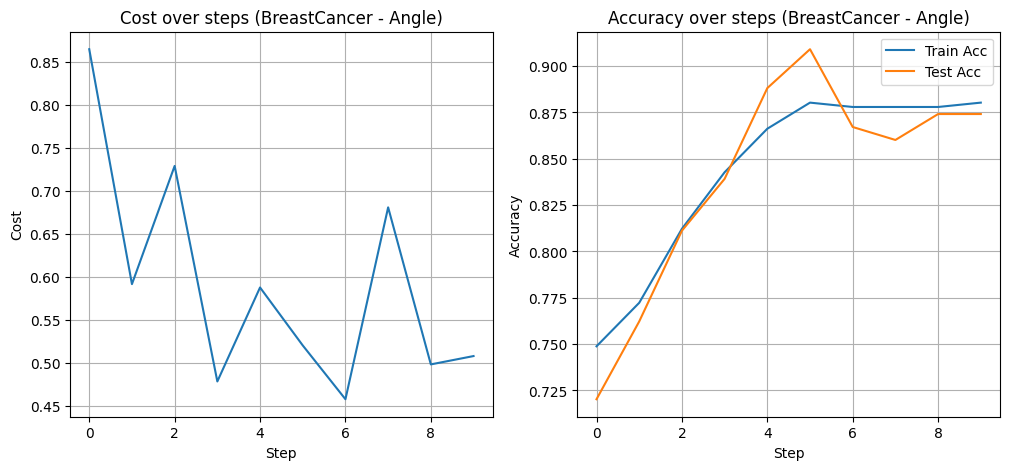

In [35]:
#Breast Cancer angle embedding quick run
X_bc, y_bc = load_breast_cancer(n_components=2)
Xb_train, Xb_test, yb_train, yb_test = train_test_split(X_bc, y_bc, test_size=0.25, random_state=0)

n_wires = 2
n_layers = 3
dev = qml.device("default.qubit", wires=n_wires)
circ_angle = angle_vqc_circuit(n_wires, n_layers, dev)
weights_shape = (n_layers, n_wires, 3)

res_bc = train_generic_vqc(circ_angle, weights_shape, Xb_train, yb_train, Xb_test, yb_test,
                           optimizer='Adam', lr=0.1, steps=10, batch_size=16, seed=7)

plot_cost_and_acc(res_bc['costs'], res_bc['train_accs'], res_bc['test_accs'], title_suffix="(BreastCancer - Angle)")

In [36]:
#Run amplitude embedding on Wine 2-class (PCA to 4 features to use 2 qubits for amplitude embedding).

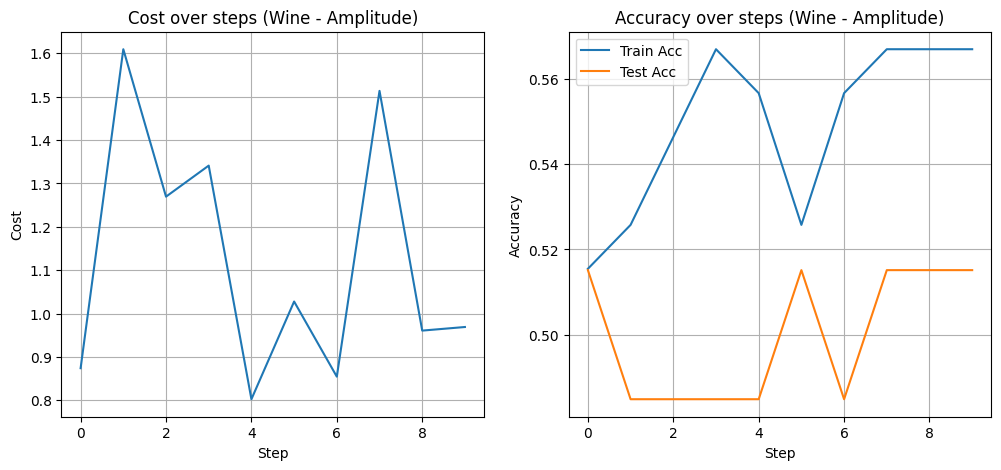

In [37]:
#Wine amplitude embedding quick run
X_w, y_w = load_wine_2class(n_components=4) # 4 features for 2 qubits amplitude
Xw_train, Xw_test, yw_train, yw_test = train_test_split(X_w, y_w, test_size=0.25, random_state=0)

n_wires = 2      
n_layers = 3
dev = qml.device("default.qubit", wires=n_wires)
circ_amp = amplitude_vqc_circuit(n_wires, n_layers, dev)
weights_shape_amp = (n_layers, n_wires, 3)

res_wine = train_generic_vqc(circ_amp, weights_shape_amp, Xw_train, yw_train, Xw_test, yw_test,
                             optimizer='Adam', lr=0.1, steps=10, batch_size=16, seed=8)

plot_cost_and_acc(res_wine['costs'], res_wine['train_accs'], res_wine['test_accs'], title_suffix="(Wine - Amplitude)")

In [38]:
#Compare optimizers (Adam vs Nesterov vs GradientDescent) for Iris angle vqc and simulate noise using default.mixed device to gauge degradation.

Running optimizer: Adam
Running optimizer: Nesterov
Running optimizer: GradientDescent


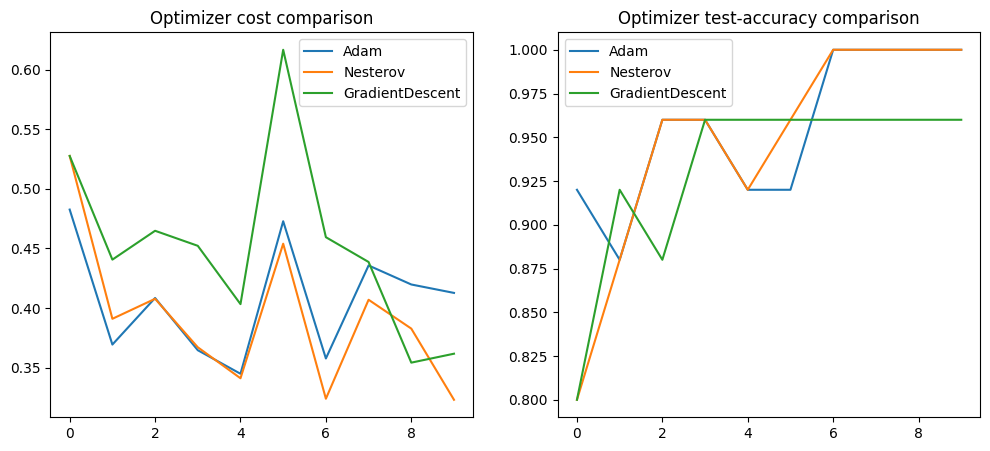

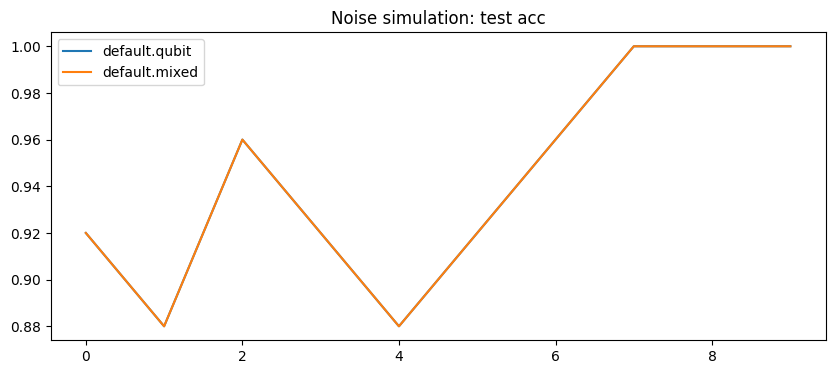

In [39]:
#Optimizer comparison (Iris 2-feature angle VQC)
X_i, y_i = load_iris_2features()
Xi_train, Xi_test, yi_train, yi_test = train_test_split(X_i, y_i, test_size=0.25, random_state=0)
n_wires = 2; n_layers = 3

dev = qml.device("default.qubit", wires=n_wires)
circ_i = angle_vqc_circuit(n_wires, n_layers, dev)
wshape_i = (n_layers, n_wires, 3)

optimizers = ['Adam', 'Nesterov', 'GradientDescent']
opt_results = {}
for opt_name in optimizers:
    print("Running optimizer:", opt_name)
    res = train_generic_vqc(circ_i, wshape_i, Xi_train, yi_train, Xi_test, yi_test,
                            optimizer=opt_name, lr=0.1, steps=10, batch_size=16, seed=9)
    opt_results[opt_name] = res

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
for k,v in opt_results.items():
    plt.plot(v['costs'], label=k)
plt.title("Optimizer cost comparison")
plt.legend()
plt.subplot(1,2,2)
for k,v in opt_results.items():
    plt.plot(v['test_accs'], label=k)
plt.title("Optimizer test-accuracy comparison")
plt.legend()
plt.show()

# Noise simulation: default.mixed vs default.qubit on Iris angle
dev_qubit = qml.device("default.qubit", wires=n_wires)
dev_mixed = qml.device("default.mixed", wires=n_wires)
circ_qubit = angle_vqc_circuit(n_wires, n_layers, dev_qubit)
circ_mixed = angle_vqc_circuit(n_wires, n_layers, dev_mixed)

res_qubit = train_generic_vqc(circ_qubit, wshape_i, Xi_train, yi_train, Xi_test, yi_test, optimizer='Adam', steps=20, seed=7)
res_mixed = train_generic_vqc(circ_mixed, wshape_i, Xi_train, yi_train, Xi_test, yi_test, optimizer='Adam', steps=20, seed=7)

plt.figure(figsize=(10,4))
plt.plot(res_qubit['test_accs'], label='default.qubit')
plt.plot(res_mixed['test_accs'], label='default.mixed')
plt.title("Noise simulation: test acc")
plt.legend()
plt.show()


In [40]:
#Train several models with different seeds and perform majority voting on Iris test set. Then compute confusion matrix & classification report.


Ensemble majority-vote accuracy: 1.0


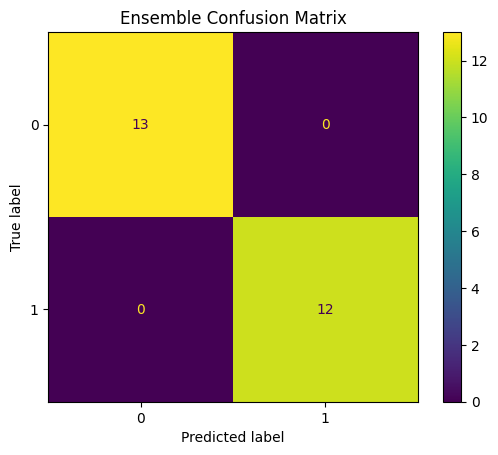

Classification report (ensemble):
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        12

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25



In [41]:
#Ensemble of VQCs (Iris angle)
n_models = 3
models = []
for s in range(n_models):
    m = train_generic_vqc(circ_i, wshape_i, Xi_train, yi_train, Xi_test, yi_test,
                          optimizer='Adam', lr=0.1, steps=10, batch_size=16, seed=7)
    models.append(m)

# collect predictions on test set
preds_models = []
for m in models:
    w = m['weights']; b = m['bias']
    preds = [np.sign(circ_i(w, x) + b) for x in Xi_test]
    preds_models.append([int(float(p)) for p in preds])

preds_models = onp.array(preds_models) # shape (n_models, n_samples)
maj_vote = []
for j in range(preds_models.shape[1]):
    col = preds_models[:, j]
    ones = onp.sum(col == 1)
    negs = onp.sum(col == -1)
    maj = 1 if ones > negs else -1
    maj_vote.append(maj)
maj_vote = onp.array(maj_vote)

ensemble_acc = onp.mean(maj_vote == yi_test)
print("Ensemble majority-vote accuracy:", ensemble_acc)

# Confusion matrix & classification report
y_true_binary = ((yi_test + 1)//2).astype(int)
y_pred_binary = ((maj_vote + 1)//2).astype(int)
cm = confusion_matrix(y_true_binary, y_pred_binary)
ConfusionMatrixDisplay(cm).plot()
plt.title("Ensemble Confusion Matrix")
plt.show()
print("Classification report (ensemble):")
print(classification_report(yi_test, maj_vote, target_names=["-1","1"]))


In [42]:
#Create (automatically) and save key model weights to vqc_artifacts folder.

In [43]:
print("Creating working directory..")

folder = "vqc_artifacts"
os.makedirs(folder, exist_ok=True)

# verify data exists
print("weights:", weights)
print("bias:", bias)
print("res_bc:", res_bc)

# save tutorial iris weights
iris_path = os.path.join(folder, "iris_tutorial_weights.pkl")
with open(iris_path, "wb") as f:
    pickle.dump({"weights": weights.tolist(), "bias": float(bias)}, f)

# save one extension model
bc_path = os.path.join(folder, "bc_angle_weights.pkl")
with open(bc_path, "wb") as f:
    pickle.dump({"weights": res_bc['weights'].tolist(), "bias": float(res_bc['bias'])}, f)

print("Artifacts saved to:", folder)
print("Saved files:", os.listdir(folder))

Creating working directory..
weights: [[[ 8.04365166e-03  3.55852448e-01  1.58720609e-02]
  [ 2.05509196e-02 -6.75884496e-01 -1.97486761e-03]]

 [[-2.42411596e-03  3.52299321e-01 -3.12789164e-03]
  [-2.35953180e-04 -4.03854129e-01  1.35296586e-02]]

 [[ 5.33233106e-03  5.33486498e-01 -2.46867166e-03]
  [-8.73614326e-03 -4.71641049e-01  5.91951379e-04]]

 [[-1.24585667e-02  5.85873384e-01 -8.50763309e-03]
  [ 4.31937077e-03 -2.02498978e-01 -1.92460754e-02]]

 [[ 1.06539072e-02  6.22571608e-01  1.43109385e-02]
  [ 1.32742565e-02 -2.45258481e-01  1.39177440e-03]]

 [[-4.83154906e-03  6.95839501e-01  4.72148998e-03]
  [ 8.19917293e-03  9.07519617e-03 -5.85822875e-03]]]
bias: -0.20597506580566183
res_bc: {'weights': tensor([[[ 0.06284594,  0.72531467, -0.3123278 ],
         [ 0.48186246, -0.51248573,  0.2670111 ]],

        [[ 0.26698154, -0.05644402, -0.44251416],
         [ 0.19434387,  0.50591966, -0.00171548]],

        [[ 0.00505299, -0.00261356, -0.00242749],
         [ 0.46562731, -0

In [44]:
#Quantum models completed.
#Now we compare our quantum model to classical ML models: 
# - Logistic Regression
# - Linear SVM
# - RBF SVM
# - Random Forest

In [45]:
#Classical ML Baseline Comparison (LogReg, SVM, RF)

def evaluate_baseline_models(X_train, y_train, X_test, y_test):
    models = {
        "Logistic Regression": LogisticRegression(max_iter=500),
        "Linear SVM": SVC(kernel='linear'),
        "RBF SVM": SVC(kernel='rbf'),
        "Random Forest": RandomForestClassifier(n_estimators=150),
    }
    
    results = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        acc = model.score(X_test, y_test)
        results[name] = acc
        print(f"{name}: accuracy = {acc:.4f}")
    return results

print("... Classical Baseline Comparison: Breast Cancer Dataset ...")
baseline_bc = evaluate_baseline_models(Xb_train, yb_train, Xb_test, yb_test)

print("\n... Classical Baseline Comparison: Wine Dataset ...")
baseline_wine = evaluate_baseline_models(Xw_train, yw_train, Xw_test, yw_test)

... Classical Baseline Comparison: Breast Cancer Dataset ...
Logistic Regression: accuracy = 0.9441
Linear SVM: accuracy = 0.9510
RBF SVM: accuracy = 0.9371
Random Forest: accuracy = 0.9371

... Classical Baseline Comparison: Wine Dataset ...
Logistic Regression: accuracy = 0.9394
Linear SVM: accuracy = 0.9394
RBF SVM: accuracy = 0.9697
Random Forest: accuracy = 0.9697


Running circuit depth experiments...

... Testing depth L = 1 ...
Depth 1 → final test accuracy = 0.6400

... Testing depth L = 2 ...
Depth 2 → final test accuracy = 0.8400

... Testing depth L = 3 ...
Depth 3 → final test accuracy = 1.0000

... Testing depth L = 4 ...
Depth 4 → final test accuracy = 1.0000

... Testing depth L = 6 ...
Depth 6 → final test accuracy = 1.0000

... Testing depth L = 8 ...
Depth 8 → final test accuracy = 1.0000


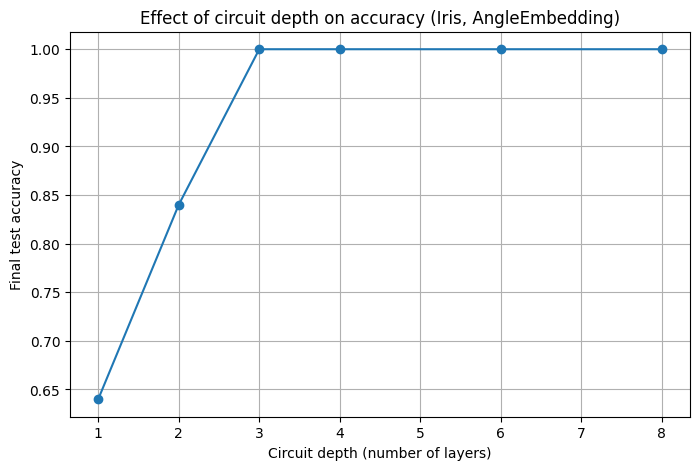

In [46]:
#Sweep circuit depth (number of layers) for Iris dataset

depths = [1, 2, 3, 4, 6, 8]
depth_results = {}

print("Running circuit depth experiments...")

for L in depths:
    print(f"\n... Testing depth L = {L} ...")
    n_wires = 2
    dev = qml.device("default.qubit", wires=n_wires)
    circ_sweep = angle_vqc_circuit(n_wires, L, dev)
    
    wshape = (L, n_wires, 3)
    res = train_generic_vqc(circ_sweep, wshape, Xi_train, yi_train, Xi_test, yi_test,
                            optimizer='Adam', steps=10, seed=7)
    
    depth_results[L] = res['test_accs'][-1]
    print(f"Depth {L} → final test accuracy = {res['test_accs'][-1]:.4f}")

plt.figure(figsize=(8,5))
plt.plot(depth_results.keys(), depth_results.values(), marker='o')
plt.xlabel("Circuit depth (number of layers)")
plt.ylabel("Final test accuracy")
plt.title("Effect of circuit depth on accuracy (Iris, AngleEmbedding)")
plt.grid(True)
plt.show()

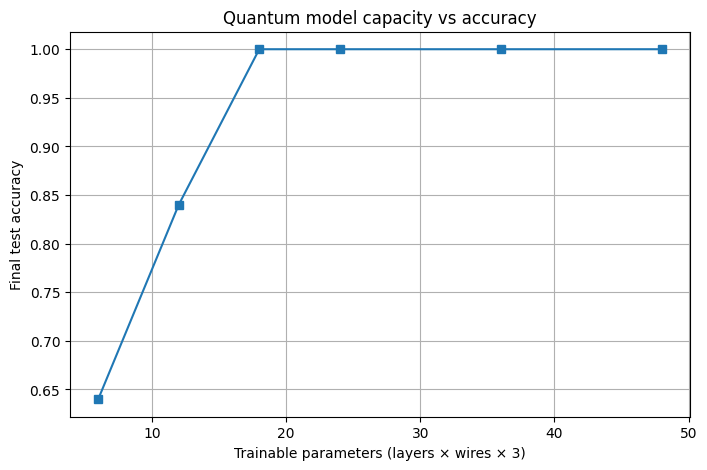

In [47]:
#Parameter count vs accuracy
param_counts = [L * 2 * 3 for L in depths] # 2 wires × 3 rotation params per wire

plt.figure(figsize=(8,5))
plt.plot(param_counts, list(depth_results.values()), marker='s')
plt.xlabel("Trainable parameters (layers × wires × 3)")
plt.ylabel("Final test accuracy")
plt.title("Quantum model capacity vs accuracy")
plt.grid(True)
plt.show()


... Testing noise level = 0.0 ...
Noise 0.0 → accuracy = 0.9600

... Testing noise level = 0.01 ...
Noise 0.01 → accuracy = 0.9600

... Testing noise level = 0.05 ...
Noise 0.05 → accuracy = 0.9600

... Testing noise level = 0.1 ...
Noise 0.1 → accuracy = 0.9200

... Testing noise level = 0.2 ...
Noise 0.2 → accuracy = 0.8800


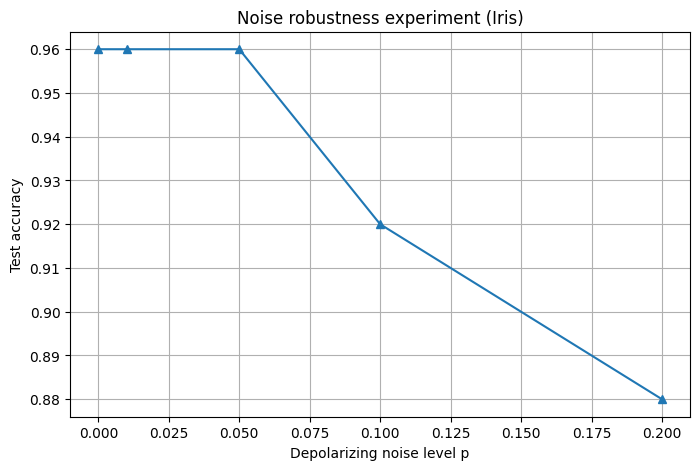

In [48]:
#Depolarizing noise sweep on Iris dataset
def angle_vqc_circuit_with_noise(n_wires, n_layers, device, noise_level):
    wires = list(range(n_wires))

    @qml.qnode(device, interface='autograd')
    def circ(weights, x):
        qml.AngleEmbedding(x, wires=wires, rotation="Y")
        for l in range(n_layers):
            qml.StronglyEntanglingLayers(weights, wires=wires)
            # Insert noise after each layer
            for w in wires:
                qml.DepolarizingChannel(noise_level, wires=w)
        return qml.expval(qml.PauliZ(0))

    return circ


# Sweep noise levels
noise_levels = [0.0, 0.01, 0.05, 0.1, 0.2]
noise_results = {}

for nl in noise_levels:
    print(f"\n... Testing noise level = {nl} ...")

    # Default mixed device (no noise model passed here)
    dev_noise = qml.device("default.mixed", wires=2)

    # Build noisy circuit
    circ_noise = angle_vqc_circuit_with_noise(
        n_wires=2,
        n_layers=3,
        device=dev_noise,
        noise_level=nl
    )

    # Train for quick evaluation
    res = train_generic_vqc(
        circ_noise, 
        (3,2,3), 
        Xi_train, yi_train, 
        Xi_test, yi_test,
        optimizer="Adam", 
        steps=10, 
        seed=8
    )

    acc = res["test_accs"][-1]
    noise_results[nl] = acc
    print(f"Noise {nl} → accuracy = {acc:.4f}")


# Plot results
plt.figure(figsize=(8,5))
plt.plot(noise_levels, list(noise_results.values()), marker='^')
plt.xlabel("Depolarizing noise level p")
plt.ylabel("Test accuracy")
plt.title("Noise robustness experiment (Iris)")
plt.grid(True)
plt.show()

In [49]:
#Train on one dataset, test on another
def match_dim(x, target_dim):
    if x.shape[1] == target_dim:
        return x
    if x.shape[1] > target_dim:
        return x[:, :target_dim]              # truncate
    else:
        pad = np.zeros((x.shape[0], target_dim - x.shape[1]))
        return np.hstack([x, pad])            # zero-pad

def train_and_transfer(train_X, train_y, test_X, test_y, name):
    print(f"\n... Transfer Learning Experiment: {name} ...")

    n_features = train_X.shape[1]
    n_wires = n_features

    # reshape test set to same input dimension
    test_X_adj = match_dim(test_X, n_features)

    dev = qml.device("default.qubit", wires=n_wires)
    circ = angle_vqc_circuit(n_wires, 3, dev)

    weights_shape = (3, n_wires, 3)

    res = train_generic_vqc(
        circ, weights_shape,
        train_X, train_y,
        test_X_adj, test_y,
        optimizer='Adam',
        steps=10,
        seed=9
    )

    acc = res['test_accs'][-1]
    print(f"Final transfer accuracy: {acc:.4f}\n")
    return acc

acc_I_to_W = train_and_transfer(Xi_train, yi_train, Xw_test, yw_test, "Iris → Wine")
acc_W_to_B = train_and_transfer(Xw_train, yw_train, Xb_test, yb_test, "Wine → BreastCancer")
acc_B_to_I = train_and_transfer(Xb_train, yb_train, Xi_test, yi_test, "BreastCancer → Iris")



... Transfer Learning Experiment: Iris → Wine ...
Final transfer accuracy: 0.3030


... Transfer Learning Experiment: Wine → BreastCancer ...
Final transfer accuracy: 0.9161


... Transfer Learning Experiment: BreastCancer → Iris ...
Final transfer accuracy: 0.7600

